# Cluster stats

In [1]:
from itertools import chain, combinations

from collections import OrderedDict as odict
from collections import defaultdict as ddict

from math import ceil

import rdkit.Chem.Scaffolds.MurckoScaffold as MurckoScaffold

from scipy.spatial.distance import pdist

from sklearn.cluster import AffinityPropagation

from itertools import takewhile

import pickle

import seaborn as sns

from local_utils.rdkit_utils import FP

In [2]:
sns.set()

## Reload data

In [3]:
# Cluster data...

clusterings = pickle.load(open('clusterings.pkl', 'r'))

len(clusterings)

138

,mol,FP,core_smiles,core_cluster,core_count,affinity_cluster,affinity_count
usmiles,,,,,,,
C=CC(C)(C)c1c(O)cc(O)c2c(=O)c(O)c(-c3ccc(OC)cc3)oc12,,"[0 0 0 ..., 0 0 0]",O=c1cc(-c2ccccc2)oc2ccccc12,258,43,0,6

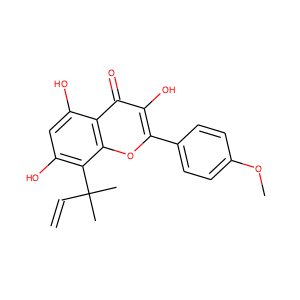

In [4]:
clusterings['ABCB1'].head(1)

## Get cluster-centric data

In [5]:
cluster_data = ddict(dict)

for symbol, clustering in clusterings.items():
    
    logging.info("Starting '{}'...".format(symbol))
    
    for method in ['core', 'affinity']:

        # Group molecules by cluster...

        def f(x):
            
            mols = x.index.values.tolist()

            return pd.Series({'mols': mols, 'count': len(mols)})

        df = clustering.groupby(method + '_cluster').apply(f)

        df.index.name = 'cluster'

        # Calculate mean similarity for molecules in clusters...

        def f(x):

            if len(x) == 1: return 0.0

            return (1.0 - pdist(list(clustering.loc[x, 'FP'].apply(lambda x: x.fp)), metric='jaccard')).mean()

        df['mean_sim'] = df['mols'].apply(f)

        # Sort and sore...

        df.sort(['count', 'mean_sim'], ascending=[0, 0], inplace=True)

        cluster_data[symbol][method] = df
        
    logging.info("...done.".format(symbol))

[2015/Aug/13 15:46:59 INFO    ] Starting 'ABCB1'...
[2015/Aug/13 15:46:59 INFO    ] ...done.
[2015/Aug/13 15:46:59 INFO    ] Starting 'ABCG2'...
[2015/Aug/13 15:46:59 INFO    ] ...done.
[2015/Aug/13 15:46:59 INFO    ] Starting 'ABL1'...
[2015/Aug/13 15:46:59 INFO    ] ...done.
[2015/Aug/13 15:46:59 INFO    ] Starting 'ACE'...
[2015/Aug/13 15:46:59 INFO    ] ...done.
[2015/Aug/13 15:46:59 INFO    ] Starting 'ACHE'...
[2015/Aug/13 15:47:00 INFO    ] ...done.
[2015/Aug/13 15:47:00 INFO    ] Starting 'ADORA1'...
[2015/Aug/13 15:47:01 INFO    ] ...done.
[2015/Aug/13 15:47:01 INFO    ] Starting 'ADORA2A'...
[2015/Aug/13 15:47:02 INFO    ] ...done.
[2015/Aug/13 15:47:02 INFO    ] Starting 'ADORA2B'...
[2015/Aug/13 15:47:02 INFO    ] ...done.
[2015/Aug/13 15:47:02 INFO    ] Starting 'ADORA3'...
[2015/Aug/13 15:47:03 INFO    ] ...done.
[2015/Aug/13 15:47:03 INFO    ] Starting 'ADRA1A'...
[2015/Aug/13 15:47:03 INFO    ] ...done.
[2015/Aug/13 15:47:03 INFO    ] Starting 'ADRA1B'...
[2015/Aug/13 1

In [6]:
len(cluster_data)

138

## Plotting

In [7]:
def do_plot(df):
    
    width = 0.6 # Width of bar

    x = np.arange(df.shape[0]) # X-axis is just index

    fig = plt.figure(figsize=(25, 8))

    ax1 = fig.add_subplot(111)
    ax1.set_title(symbol, fontsize=25)
    ax1.set_xlabel('Cluster', fontsize=20)
    ax1.set_xticks(x + width/2)
    ax1.set_xticklabels(df.index.values.tolist(), rotation=90, fontsize=8, ha='left')

    ax1.bar(x, df['count'], width=width, color='b', alpha=0.5)
    ax1.set_ylabel('Number of molecules', color='b', fontsize=18)
    for tl in ax1.get_yticklabels(): tl.set_color('b')

    ax2 = ax1.twinx()

    ax2.plot(x + width/2, df['mean_sim'], linestyle='-', marker='D', markersize=10, color='r')
    ax2.set_ylabel('Mean similarity', color='r', fontsize=20)
    for tl in ax2.get_yticklabels(): tl.set_color('r')

In [8]:
symbol = 'ABCB1'

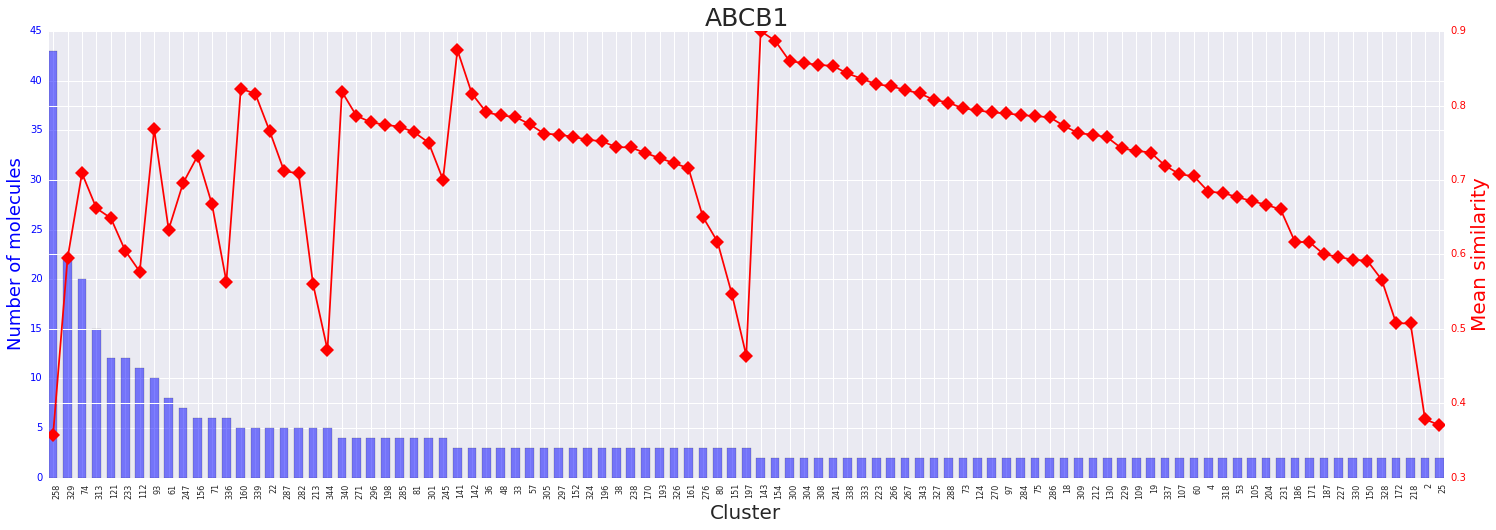

In [9]:
do_plot(cluster_data[symbol]['core'].query("count > 1"))

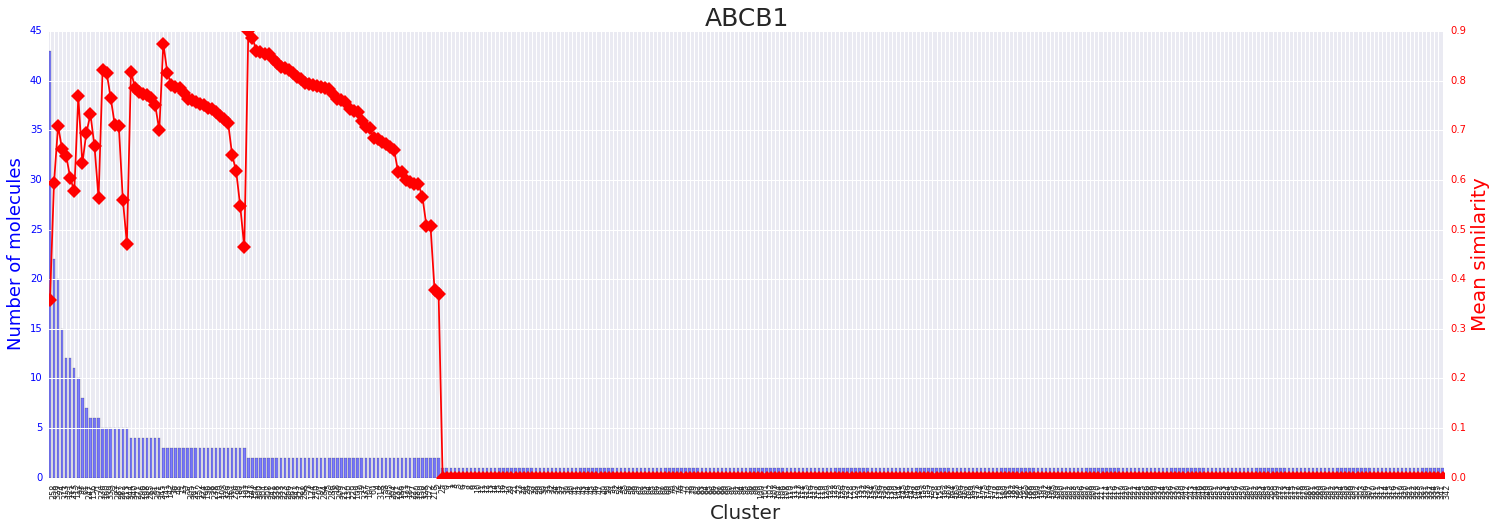

In [10]:
do_plot(cluster_data[symbol]['core'])

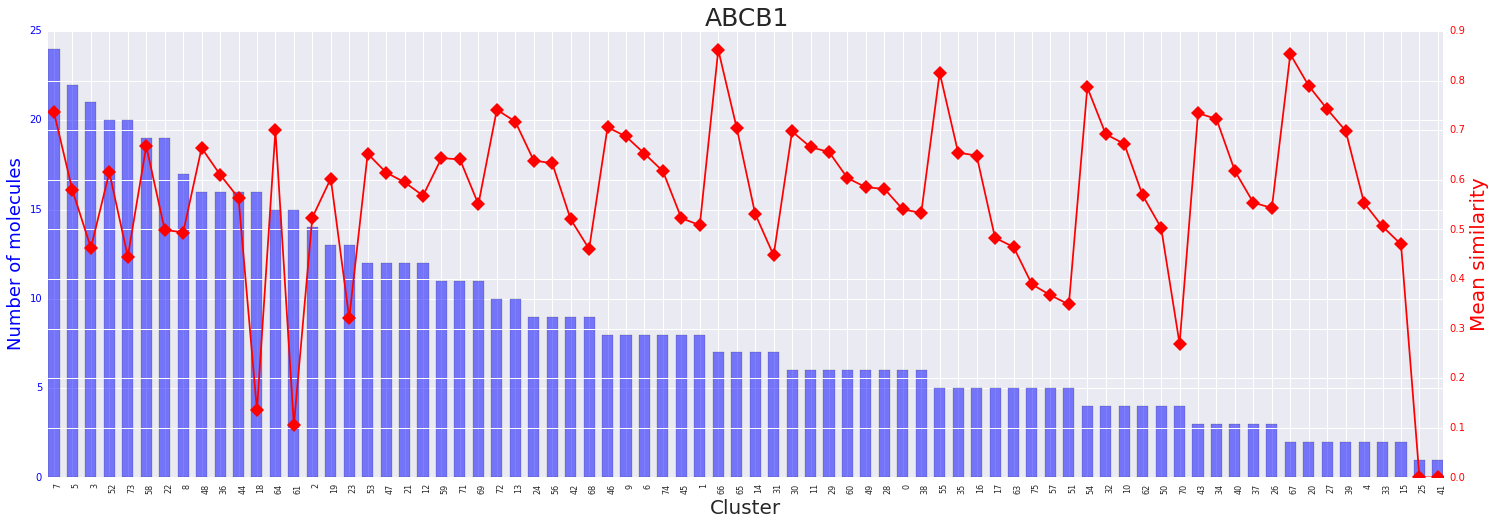

In [11]:
do_plot(cluster_data[symbol]['affinity'])

## Inspect a cluster

In [12]:
def inspect_cluster(symbol, method, cluster):
    
    mols = clusterings[symbol]
    
    record = cluster_data[symbol][method].query("cluster == @cluster").iloc[0]

    if record['count'] > 1:

        def f(x):

            return pd.Series({'mol_0': mols.loc[x[0], 'mol'], 'mol_1': mols.loc[x[1], 'mol'], 'sim': 1.0 - pdist(mols.loc[x, 'FP'].apply(lambda x: x.fp).tolist(), metric='jaccard')[0]})

        df = pd.DataFrame([f(x) for x in combinations(record['mols'], 2)])

        df.sort('sim', ascending=False, inplace=True)

        assert df.sim.mean() == record['mean_sim']

    else:

        logging.warn("'{}' cluster {} for '{}' has only one member.".format(method, cluster, symbol))

        df = pd.DataFrame()

    return df

,mol_0,mol_1,sim
2,,,0.517857
1,,,0.490196
0,,,0.383333

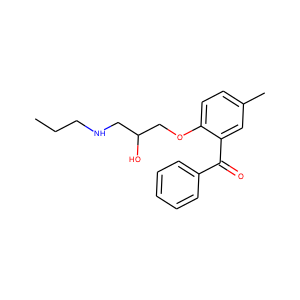
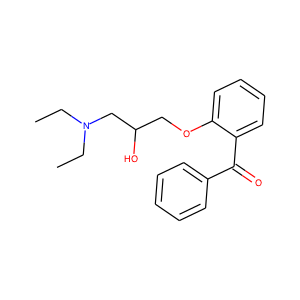
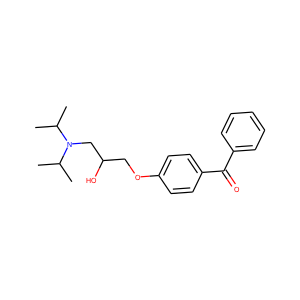
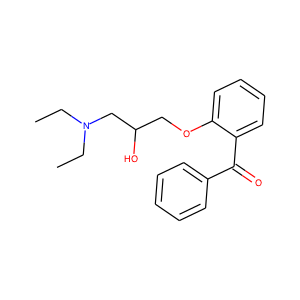
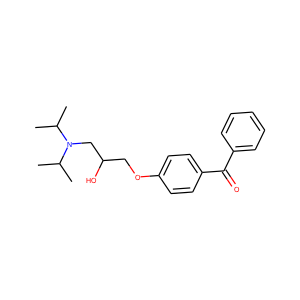
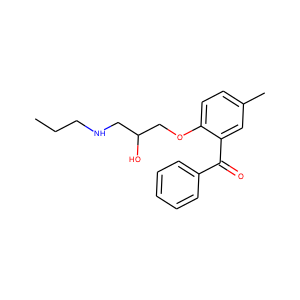

In [13]:
df = inspect_cluster(symbol, 'core' , 197)

df

,mol_0,mol_1,sim
7,,,0.982143
12,,,0.949153

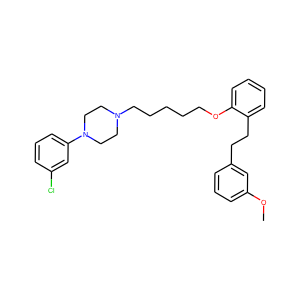
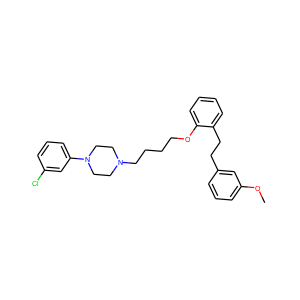
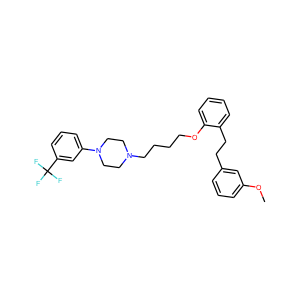
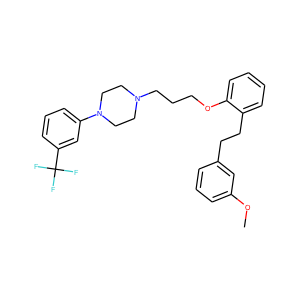

In [14]:
df = inspect_cluster(symbol, 'affinity' , 65)

df.head(2)

In [15]:
# df.tail()

## Cluster stats

In [16]:
# NB Just used to get total active compound count...

targets = pd.read_pickle('human_symbols_with_counts.pkl')

In [17]:
records = []

for n, symbol in enumerate(clusterings.keys()):

    record = [pd.DataFrame({'symbol': symbol}, index=[0]).merge(targets[['symbol', 'n_active', 'target_class']])]

    for method in ['core', 'affinity']:

        df = cluster_data[symbol][method]
        
        # Counts...

        n_total, n_multi = df.shape[0], df.query("count > 1").shape[0]

        record.append(pd.DataFrame({method + '_n_total': n_total, method + '_n_multi': n_multi, method + '_n_single': n_total - n_multi}, index=[0]))
        
        # Means...

        mean_count, mean_mean_sim = df.mean().tolist()

        record.append(pd.DataFrame({method + '_mean_count': mean_count, method + '_mean_mean_sim': mean_mean_sim}, index=[0]))

        # Means for multi-mol core clusters only...
        
        if method == 'core':

            mean_count_multi, mean_mean_sim_multi = df.query("count > 1").mean().tolist()

            record.append(pd.DataFrame({method + '_mean_count_multi': mean_count_multi, method + '_mean_mean_sim_multi': mean_mean_sim_multi}, index=[0]))

    records.append(pd.concat(record, axis=1))
        
cluster_stats = pd.concat(records, axis=0).set_index('symbol', drop=False)

cluster_stats.shape

(138, 15)

In [18]:
HTML(cluster_stats.to_html())

,symbol,n_active,target_class,core_n_multi,core_n_single,core_n_total,core_mean_count,core_mean_mean_sim,core_mean_count_multi,core_mean_mean_sim_multi,affinity_n_multi,affinity_n_single,affinity_n_total,affinity_mean_count,affinity_mean_mean_sim
symbol,,,,,,,,,,,,,,,
ABCB1,ABCB1,652,Transporter > Primary active transporter,97,248,345,1.889855,0.200606,4.164948,0.713495,74,2,76,8.578947,0.569232
ABCG2,ABCG2,266,Transporter > Primary active transporter,34,51,85,3.129412,0.279508,6.323529,0.698771,33,1,34,7.823529,0.572988
ABL1,ABL1,962,Enzyme > Kinase > Protein Kinase,107,386,493,1.951318,0.154600,5.383178,0.712314,100,0,100,9.620000,0.563336
ACE,ACE,398,Enzyme,57,130,187,2.128342,0.208466,4.701754,0.683913,41,3,44,9.045455,0.560668
ACHE,ACHE,1904,Enzyme,248,702,950,2.004211,0.182888,4.846774,0.700578,179,8,187,10.181818,0.606583
ADORA1,ADORA1,2963,Membrane receptor > G protein-coupled receptor,416,737,1153,2.569818,0.255493,5.350962,0.708133,242,0,242,12.243802,0.627730
ADORA2A,ADORA2A,3285,Membrane receptor > G protein-coupled receptor,443,860,1303,2.521105,0.239393,5.474041,0.704129,254,0,254,12.933071,0.617682
ADORA2B,ADORA2B,1584,Membrane receptor > G protein-coupled receptor,198,365,563,2.813499,0.252915,6.156566,0.719146,127,0,127,12.472441,0.628954
ADORA3,ADORA3,2874,Membrane receptor > G protein-coupled receptor,376,671,1047,2.744986,0.256320,5.859043,0.713742,234,0,234,12.282051,0.619170


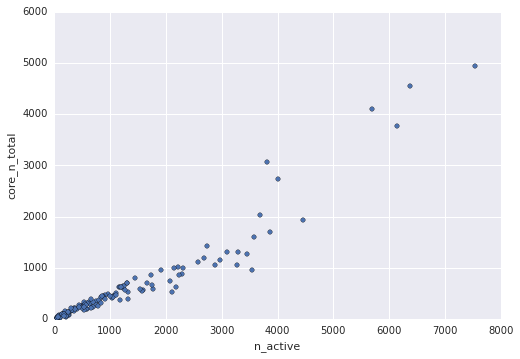

In [34]:
_ = cluster_stats.plot(x='n_active', y='core_n_total', kind='scatter', xlim=(0, 8000), ylim=(0, 6000))

In [51]:
HTML(cluster_stats.query("core_n_total > 2500").to_html())

,symbol,n_active,target_class,core_n_multi,core_n_single,core_n_total,core_mean_count,core_mean_mean_sim,core_mean_count_multi,core_mean_mean_sim_multi,affinity_n_multi,affinity_n_single,affinity_n_total,affinity_mean_count,affinity_mean_mean_sim
symbol,,,,,,,,,,,,,,,
CYP1A2,CYP1A2,6140,Enzyme > Cytochrome P450,756,3014,3770,1.628647,0.115437,4.134921,0.575660,556,3,559,10.983900,0.476508
CYP2C19,CYP2C19,6369,Enzyme > Cytochrome P450,779,3767,4546,1.401012,0.101632,3.340180,0.593091,665,3,668,9.534431,0.472807
CYP2C9,CYP2C9,5685,Enzyme > Cytochrome P450,700,3398,4098,1.387262,0.106300,3.267143,0.622312,590,2,592,9.603041,0.488869
CYP2D6,CYP2D6,4010,Enzyme > Cytochrome P450,490,2238,2728,1.469941,0.108847,3.616327,0.605987,390,6,396,10.126263,0.493089
CYP3A4,CYP3A4,7545,Enzyme > Cytochrome P450,934,4004,4938,1.527947,0.123821,3.791221,0.654633,724,4,728,10.364011,0.536790
MAPK1,MAPK1,3811,Enzyme > Kinase > Protein Kinase,330,2739,3069,1.241773,0.056838,3.248485,0.528590,322,4,326,11.690184,0.428912


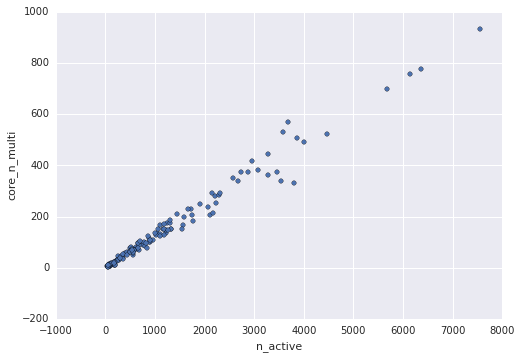

In [20]:
_ = cluster_stats.plot(x='n_active', y='core_n_multi', kind='scatter')

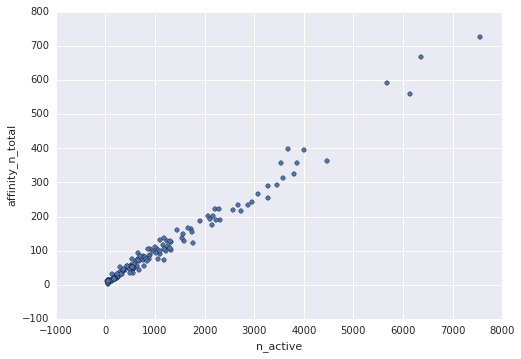

In [21]:
_ = cluster_stats.plot(x='n_active', y='affinity_n_total', kind='scatter')

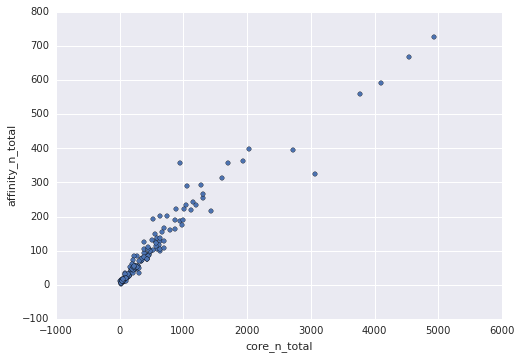

In [22]:
_ = cluster_stats.plot(x='core_n_total', y='affinity_n_total', kind='scatter')

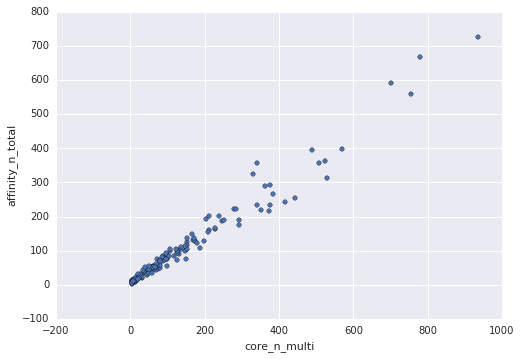

In [23]:
_ = cluster_stats.plot(x='core_n_multi', y='affinity_n_total', kind='scatter')

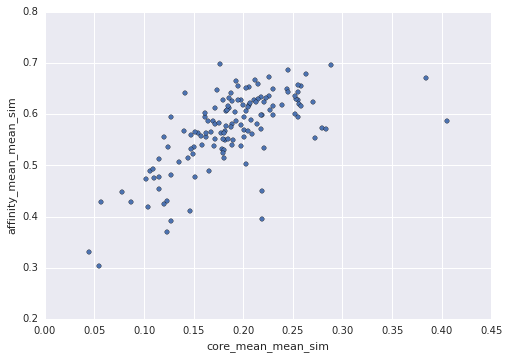

In [24]:
_ = cluster_stats.plot(x='core_mean_mean_sim', y='affinity_mean_mean_sim', kind='scatter')

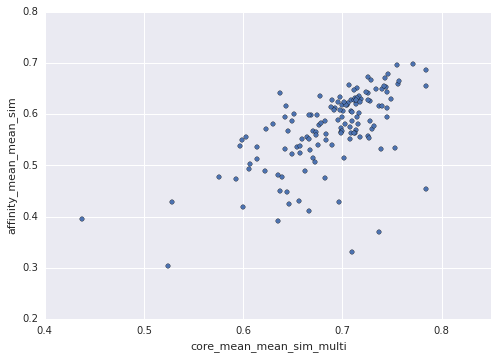

In [25]:
_ = cluster_stats.plot(x='core_mean_mean_sim_multi', y='affinity_mean_mean_sim', kind='scatter')

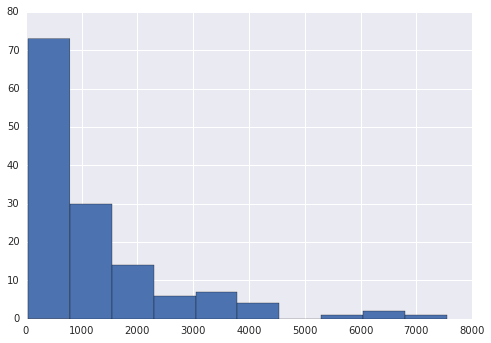

In [26]:
_ = cluster_stats['n_active'].hist()

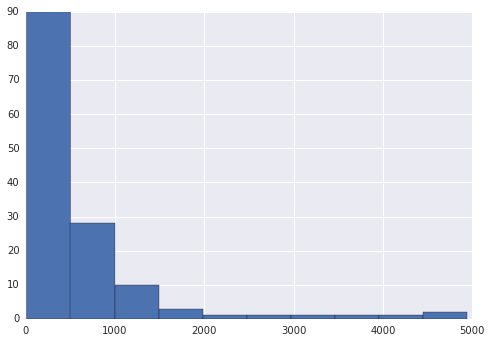

In [27]:
_ = cluster_stats['core_n_total'].hist()

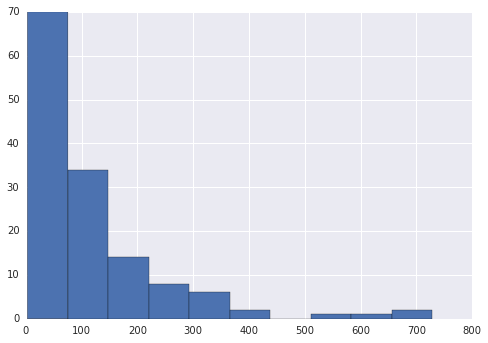

In [28]:
_ = cluster_stats['affinity_n_total'].hist()

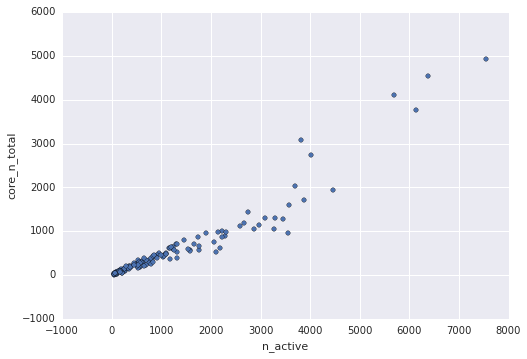

In [29]:
_ = cluster_stats.plot(x='n_active', y='core_n_total', kind='scatter')

In [44]:
def get_color_map(n_classes):

    n = int(round(n_classes/2))*2 # Round up to next even number for convenience
        
    color_map = plt.get_cmap('gist_rainbow')(np.linspace(0.0, 1.0, n))

    return color_map[list(chain.from_iterable(zip(range(0, int(n/2)), range(int(n/2), n))))[:n_classes]] # Return number requested

def do_plot(df, col, normalise=False):

    # Colour mapping...

    classes = df['target_class'].unique().tolist()

    class_numbers = [classes.index(x) for x in df['target_class']]

    color_map = get_color_map(len(classes))

    # Create Plot

    fig, ax = plt.subplots()

    fig.set_size_inches(40, 10)

    x_positions = range(df.shape[0])
    
    x_values = df[col]
    
    if normalise: x_values /= df['n_active']

    bars = ax.bar(x_positions, x_values, width=0.9, align='center', color=[color_map[x] for x in class_numbers])

    ax.set_xlim([x_positions[0]-0.5, x_positions[-1]+0.5])

    ax.set_xticks(x_positions)

    ax.tick_params(axis='both', direction='out')

    ax.set_xticklabels(df['symbol'].tolist(), rotation=45, ha='right', fontsize=8)

    ax.legend([bars[class_numbers.index(x)] for x in range(len(classes))], classes)

    plt.show()

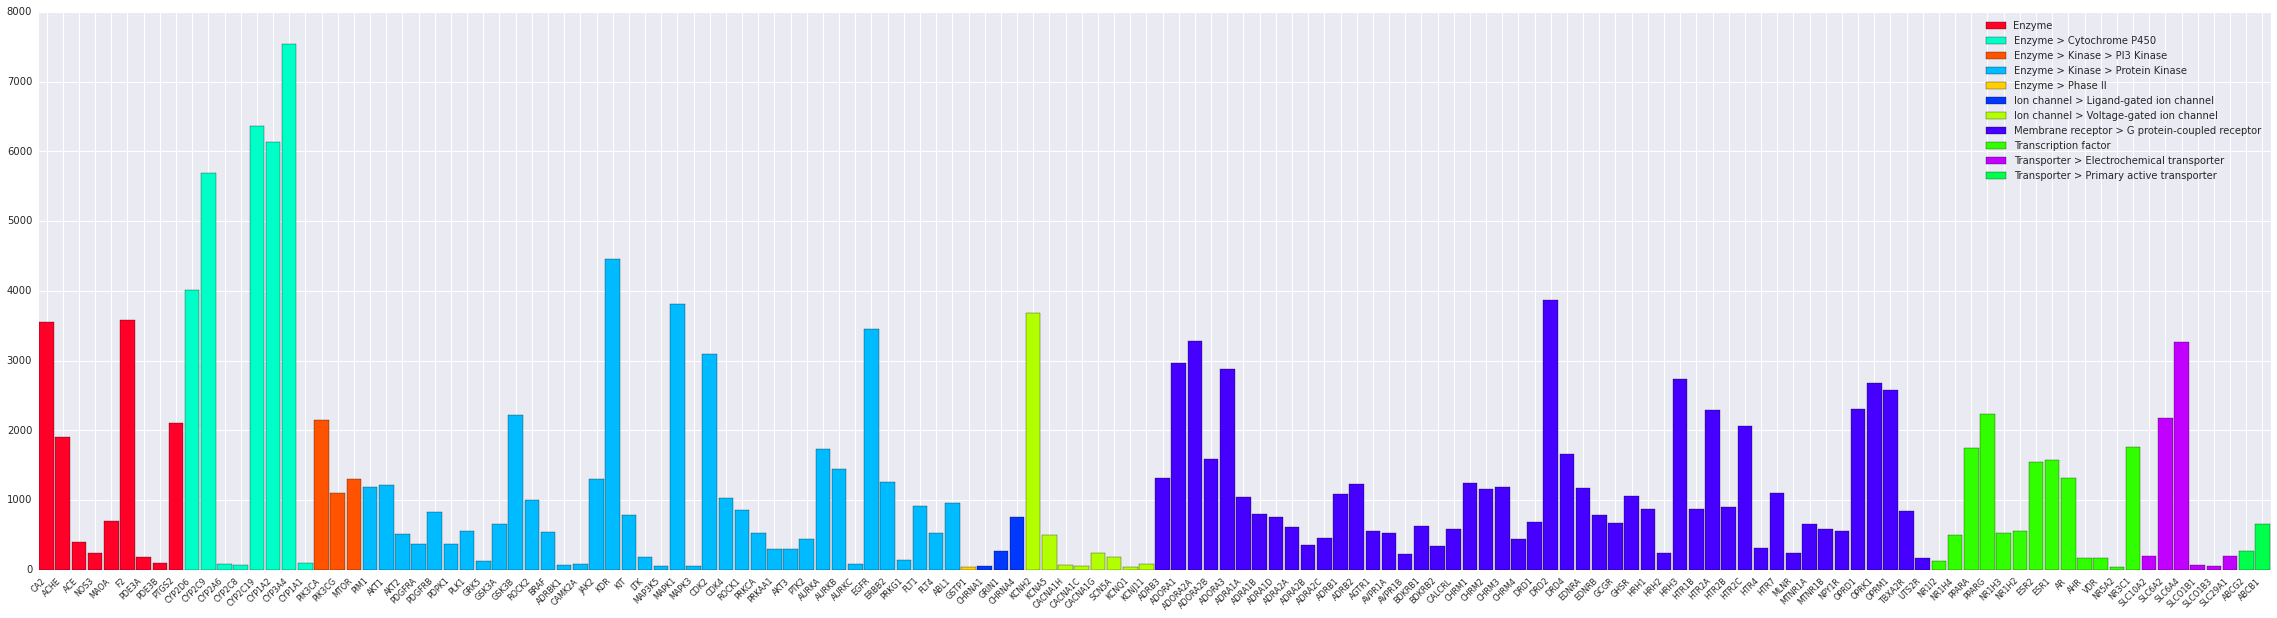

In [45]:
do_plot(cluster_stats.sort('target_class'), 'n_active')

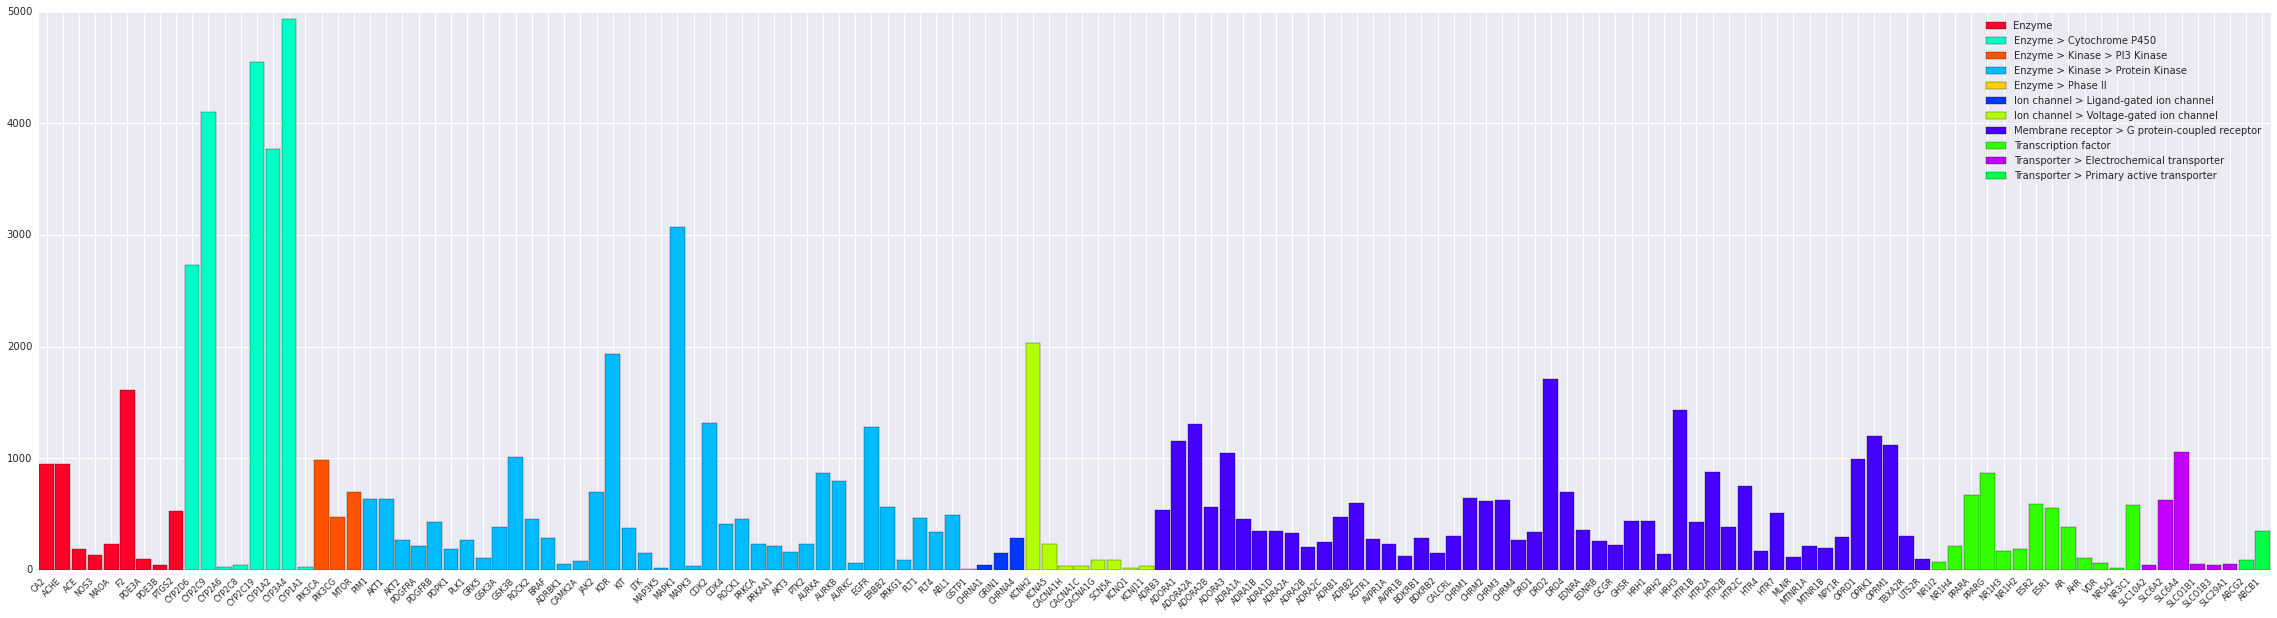

In [46]:
do_plot(cluster_stats.sort('target_class'), 'core_n_total')

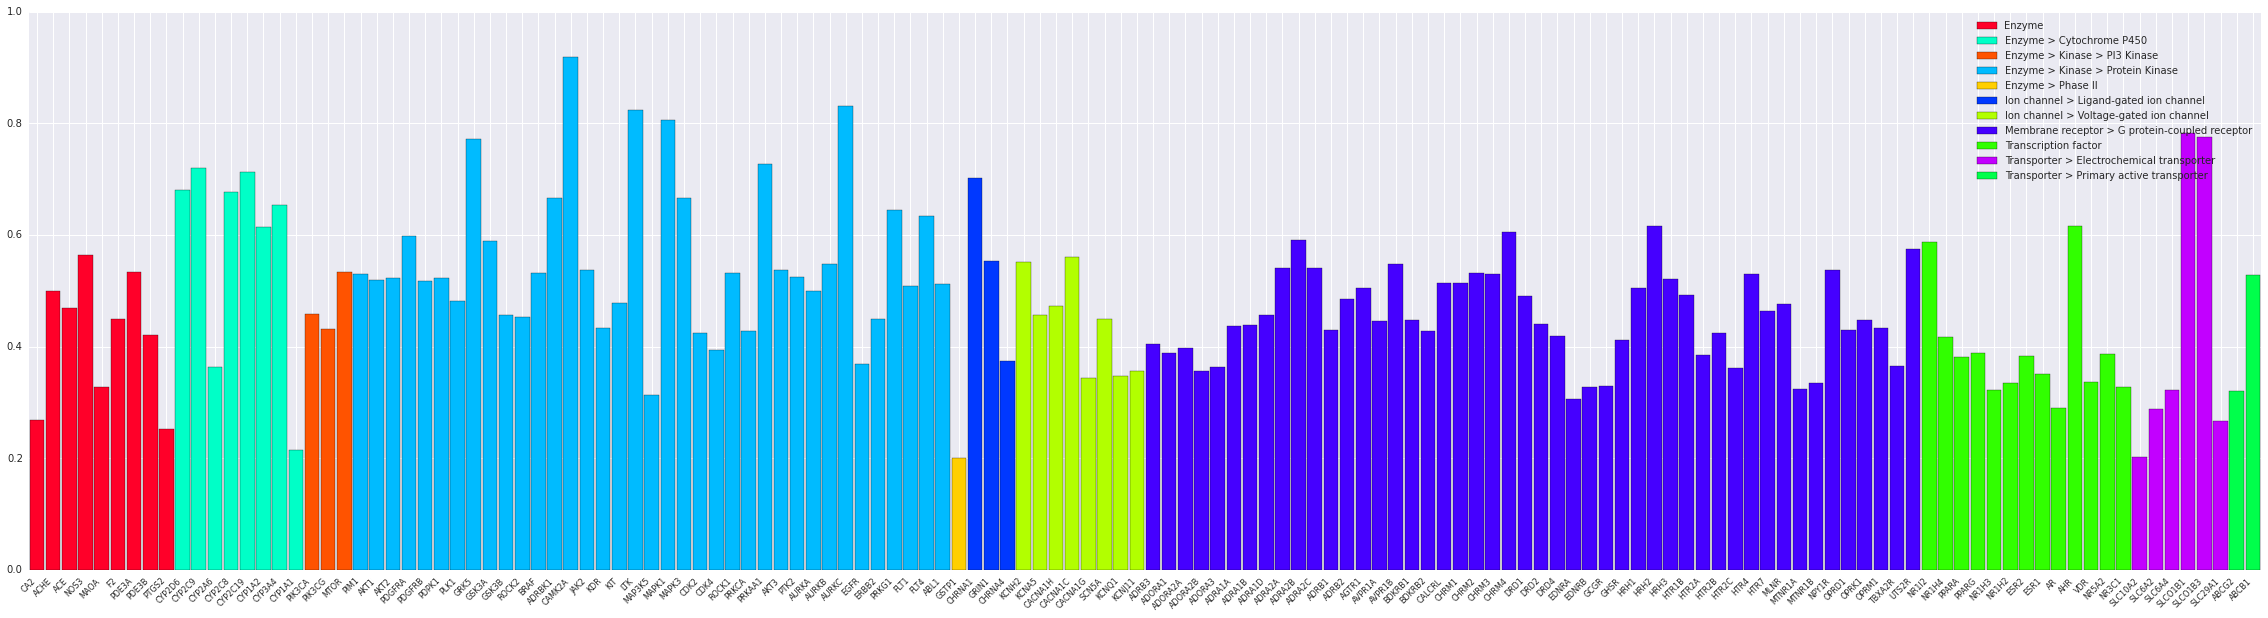

In [47]:
do_plot(cluster_stats.sort('target_class'), 'core_n_total', normalise=True)

In [55]:
HTML(cluster_stats.loc[['CAMK2A']].to_html())

,symbol,n_active,target_class,core_n_multi,core_n_single,core_n_total,core_mean_count,core_mean_mean_sim,core_mean_count_multi,core_mean_mean_sim_multi,affinity_n_multi,affinity_n_single,affinity_n_total,affinity_mean_count,affinity_mean_mean_sim
symbol,,,,,,,,,,,,,,,
CAMK2A,CAMK2A,86,Enzyme > Kinase > Protein Kinase,5,74,79,1.088608,0.044928,2.4,0.709856,11,1,12,7.166667,0.330294


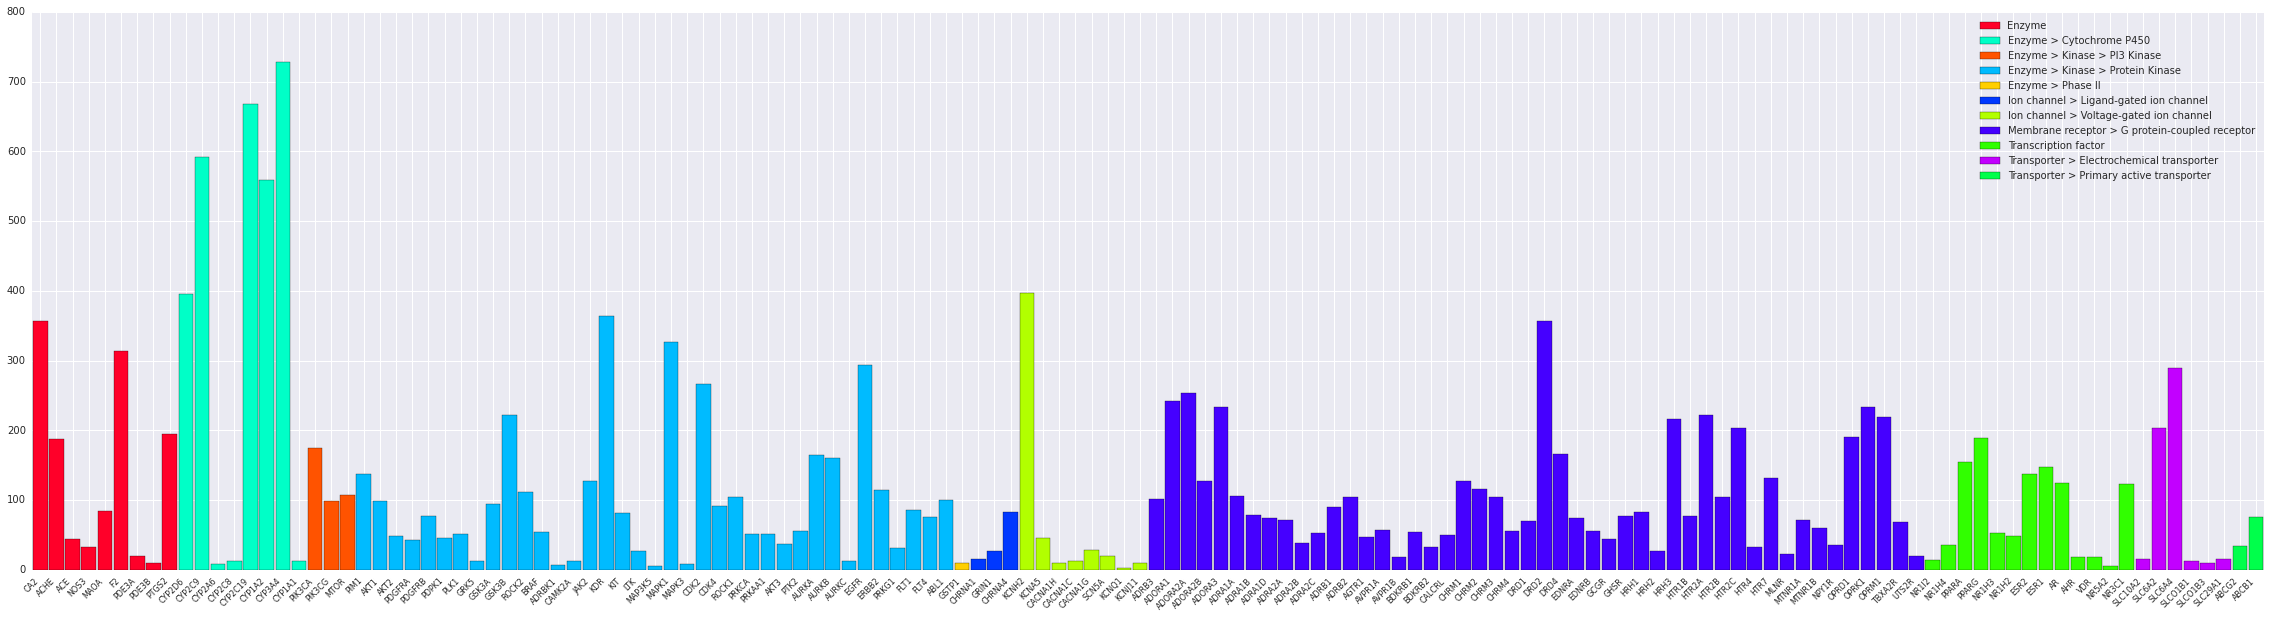

In [49]:
do_plot(cluster_stats.sort('target_class'), 'affinity_n_total')

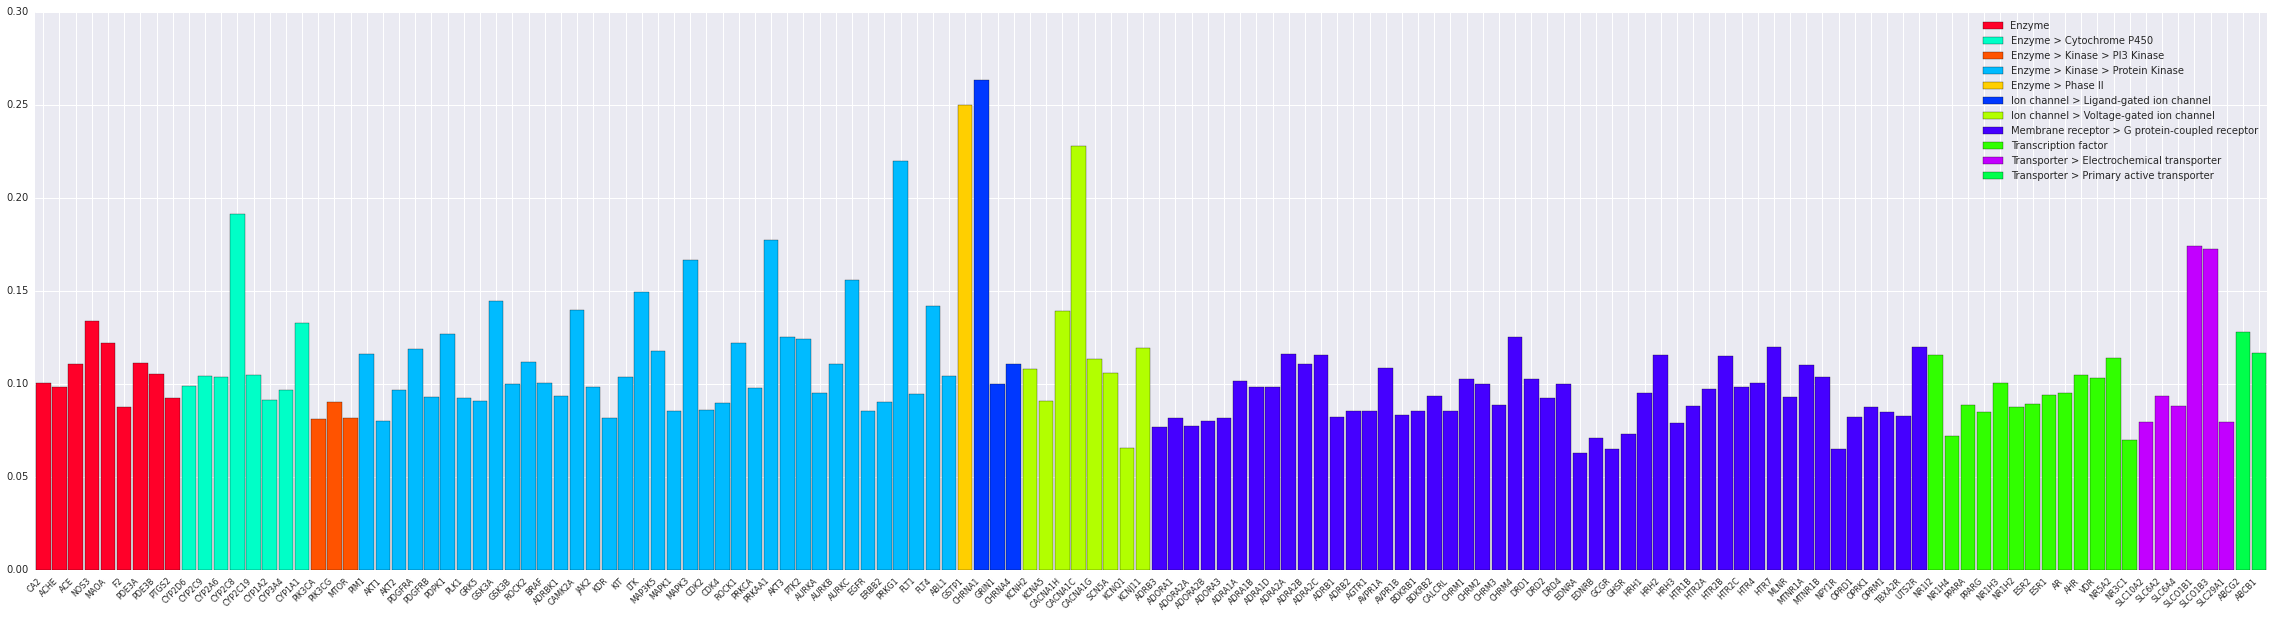

In [48]:
do_plot(cluster_stats.sort('target_class'), 'affinity_n_total', normalise=True)